Package imports and dataset download

1.- Buscar un nuevo dataset publico entre 3 a 10 clases, que tenga no mas de 1’000’000 de puntos de data y no menos de 50’000. No puedes usar MNIST, pero si otras bases de datos asocidadas a MNIST : Ejemplo: Fashion MNIST. Si fuera conveniente puedes re-scalar tu dataset a 32x32x3 si las imagenes originales son muy grandes, y dejar que ese sea tu nueva data en bruto. Deberas declarar la dimensionalidad de tu data en bruto. Por ejemplo: si las imagenes son de 32x32x3, la dimensionalidad es de 3072. Plotear 10 ejemplos de imagenes usadas en tu dataset – por lo menos 1 por clase

In [71]:
import clip
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import gridspec
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, MeanShift
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch import tensor, float32, cuda, no_grad, cat
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm

In [3]:

cifar10 = CIFAR10(root='../data', train=True, download=True)
dataset = tensor(cifar10.data.copy().reshape(cifar10.data.shape[0], -1), dtype=float32)

Files already downloaded and verified


Plotting one image per class (32x32x3 dimensionality is 3072)

Plotear 10 ejemplos de imagenes usadas en tu dataset – por lo menos 1 por clase

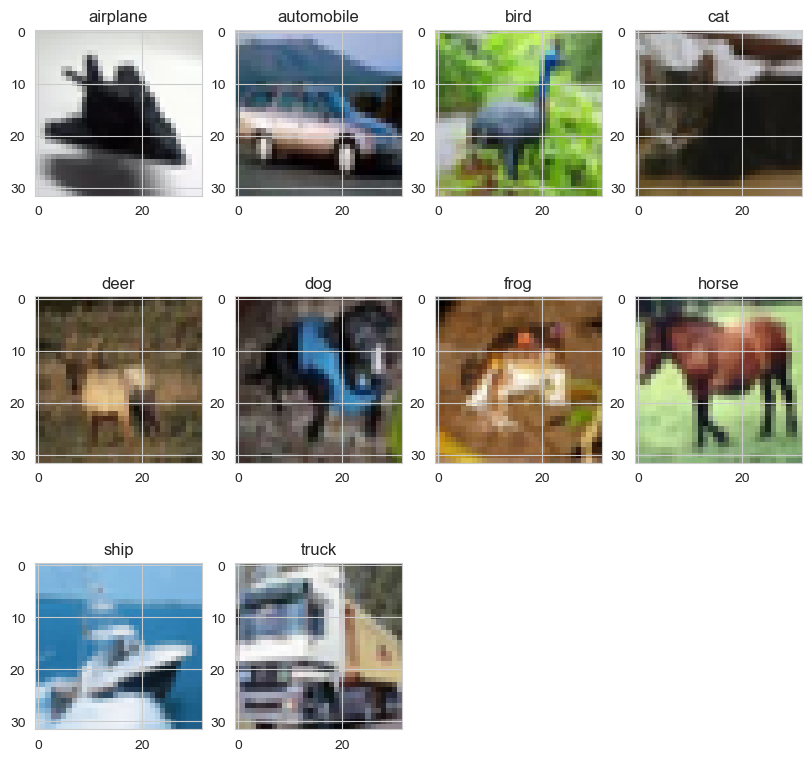

In [4]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
columns = 4
rows = 3

for img_class in range(10):
    img = cifar10.data[cifar10.targets.index(img_class)]
    fig.add_subplot(rows, columns, img_class + 1, title=cifar10.classes[img_class])
    plt.imshow(img)

2.- Proyectar tu dataset (data en bruto) a dos dimensiones usando PCA, y visualizar/plotear el dataset con un codigo de colores dependiendo de las clases. Plotear los dos eigenvectors tambien.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


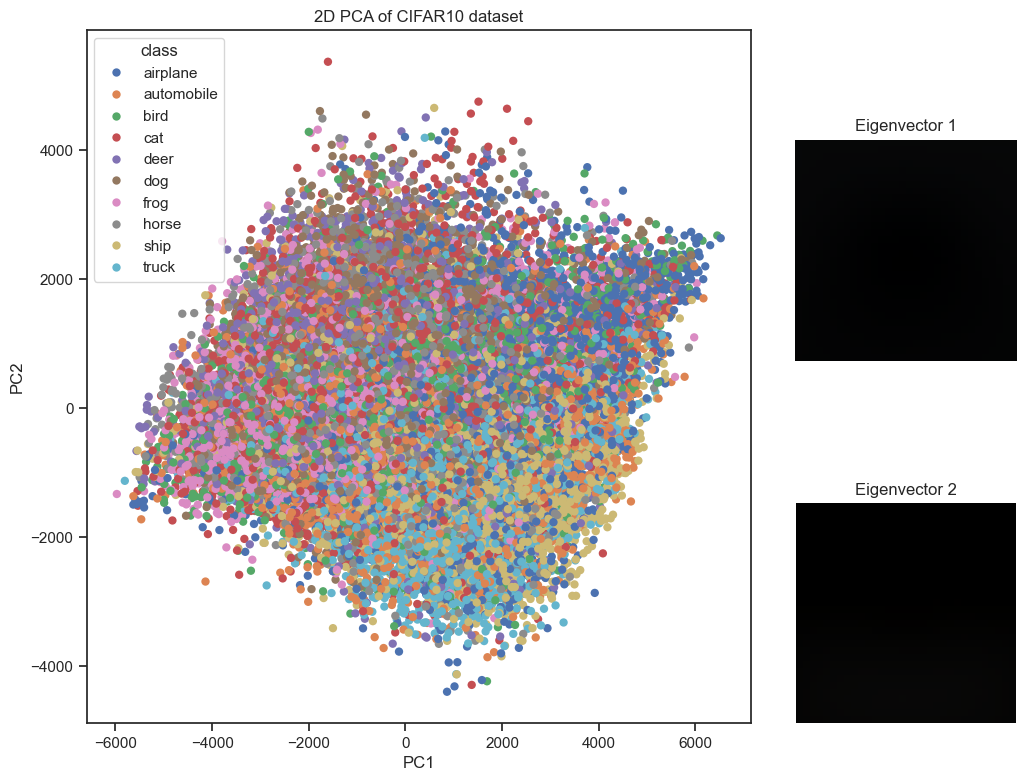

In [73]:

sns.set(style="ticks")
# sklearn PCA
pca = PCA(n_components=2)
pcaU, pcaS, pcaV = pca.fit_transform(dataset), pca.singular_values_, pca.components_

pcaU = pd.DataFrame(pcaU, columns=['PC1', 'PC2'])
pcaU['class'] = [cifar10.classes[target] for target in cifar10.targets]

#using a matplotlib grid

fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[3, 1], height_ratios=[2, 1], wspace=0.1, hspace=0.1)
#add big subplot for pca data
ax1 = fig.add_subplot(gs[:, 0])
ax1.set_title("2D PCA of CIFAR10 dataset")
#sns scatterplot
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pcaU, ax=ax1, hue_order=cifar10.classes, linewidth=0)
images = []

for img in pcaV:
    img = np.reshape(img, (32, 32, 3))
    images.append(img)

#add subplot for eigenvector 1
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(images[0])
ax2.set_title('Eigenvector 1')
ax2.axis('off')
#add subplot for eigenvector 2
ax3 = fig.add_subplot(gs[1, 1])
ax3.imshow(images[1])
ax3.set_title('Eigenvector 2')
ax3.axis('off')
plt.show()



3.- Repetir el paso anterior usando primero un embedding de tu eleccion y luego aplicar PCA al dataset hacia dos dimensiones.Visualizar/plotear el dataset con un codigo de colores dependiendo de las clases. Deberas declarar la dimension del embedding.

In [34]:
#Image embedding using CLIP
device = "cuda" if cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
cifar10embedded = CIFAR10(root='../data', train=True, download=True, transform=preprocess)
embedded_dataset = []

with no_grad():
    for image, class_id in tqdm(DataLoader(cifar10embedded, batch_size=100)):
        image_features = model.encode_image(image)
        embedded_dataset.append(image_features.to(device))
embedded_dataset = cat(embedded_dataset)

Files already downloaded and verified


100%|██████████| 500/500 [24:09<00:00,  2.90s/it]  


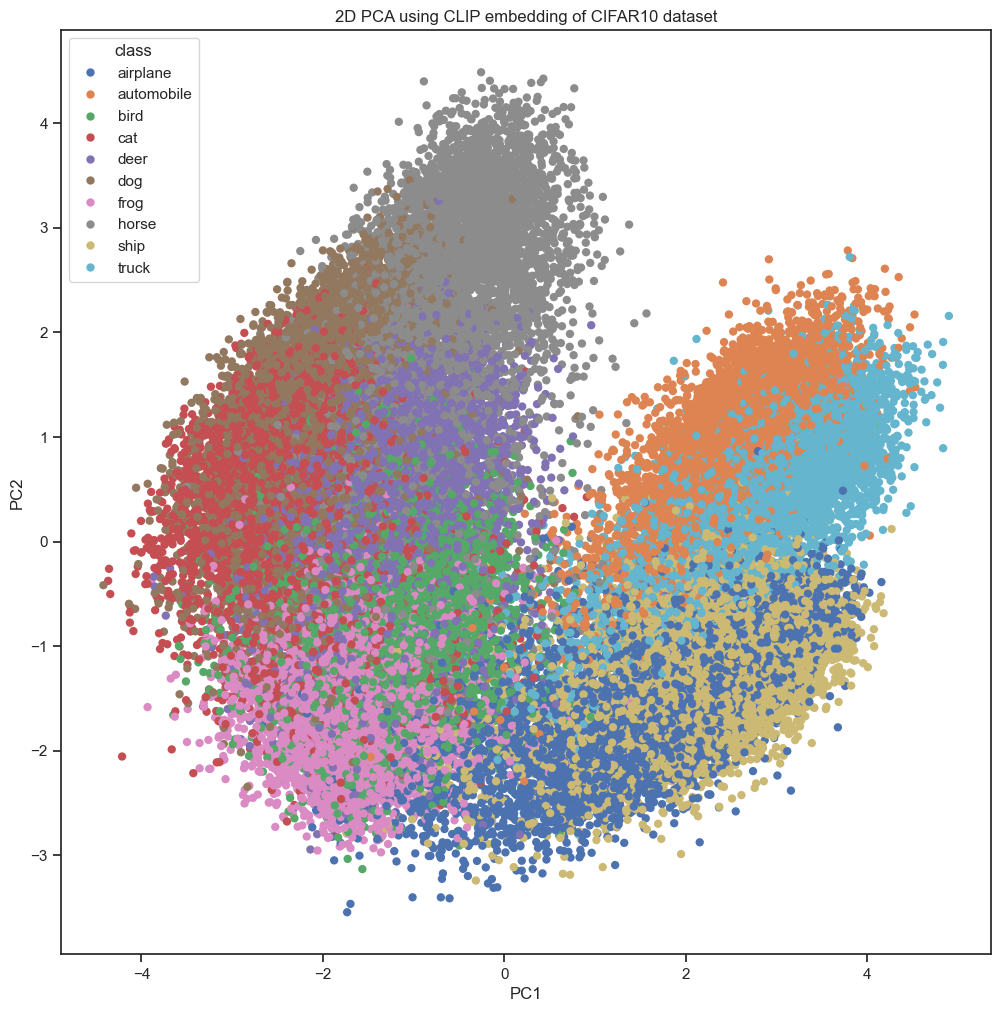

In [76]:
#Plotting the embedded dataset using PCA
pca = PCA(n_components=2)
pcaU_embedded, pcaS_embedded, pcaV_embedded = pca.fit_transform(
    embedded_dataset.cpu()), pca.singular_values_, pca.components_

sns.set(style="ticks")

pcaU_embedded = pd.DataFrame(pcaU_embedded, columns=['PC1', 'PC2'])
pcaU_embedded['class'] = [cifar10.classes[target] for target in cifar10.targets]

fig = plt.figure(figsize=(12, 12))
#add big subplot for pca data
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pcaU_embedded, hue_order=cifar10.classes, linewidth=0)
plt.title('2D PCA using CLIP embedding of CIFAR10 dataset')
plt.show()


4.- Proyectar tu dataset (data en bruto) a dos dimensiones usando t-SNE, y visualizar/plotear el dataset con un codigo de colores dependiendo de las clases.

In [78]:
#Calculating t-SNE

tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=800)
tsne_results = tsne.fit_transform(dataset)

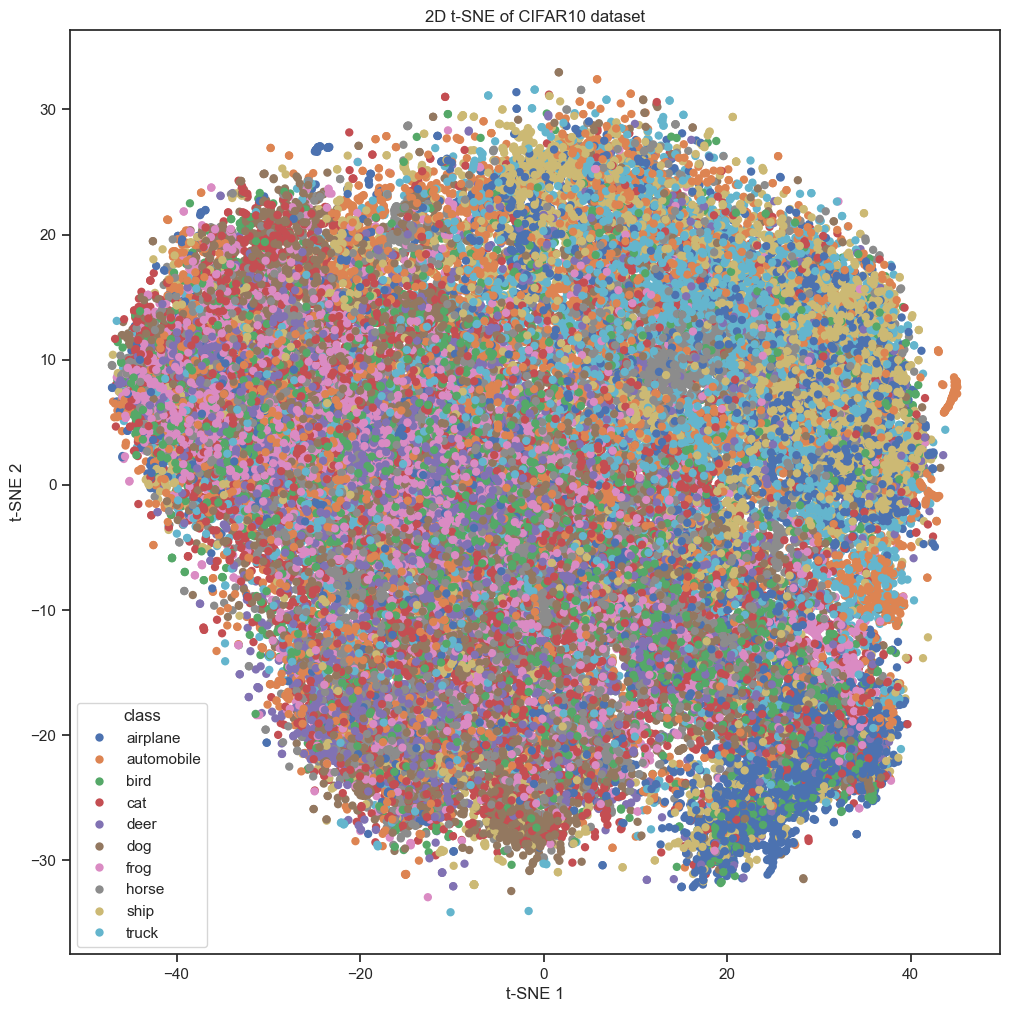

In [79]:
plt.figure(figsize=(12, 12))
tsne_results = pd.DataFrame(tsne_results, columns=['t-SNE 1', 't-SNE 2'])
tsne_results['class'] = [cifar10.classes[target] for target in cifar10.targets]

sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='class', data=tsne_results, hue_order=cifar10.classes, linewidth=0)

plt.title('2D t-SNE of CIFAR10 dataset')
plt.show()

5.- Repetir el paso anterior usando primero un embedding de tu eleccion y luego aplicar t-SNE al dataset hacia dos dimensiones. Visualizar/plotear el dataset con un codigo de colores dependiendo de las clases. Deberas declarar la dimension del embedding.

In [57]:
tsne_embedded = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=800)
tsne_results_embedded = tsne_embedded.fit_transform(embedded_dataset)

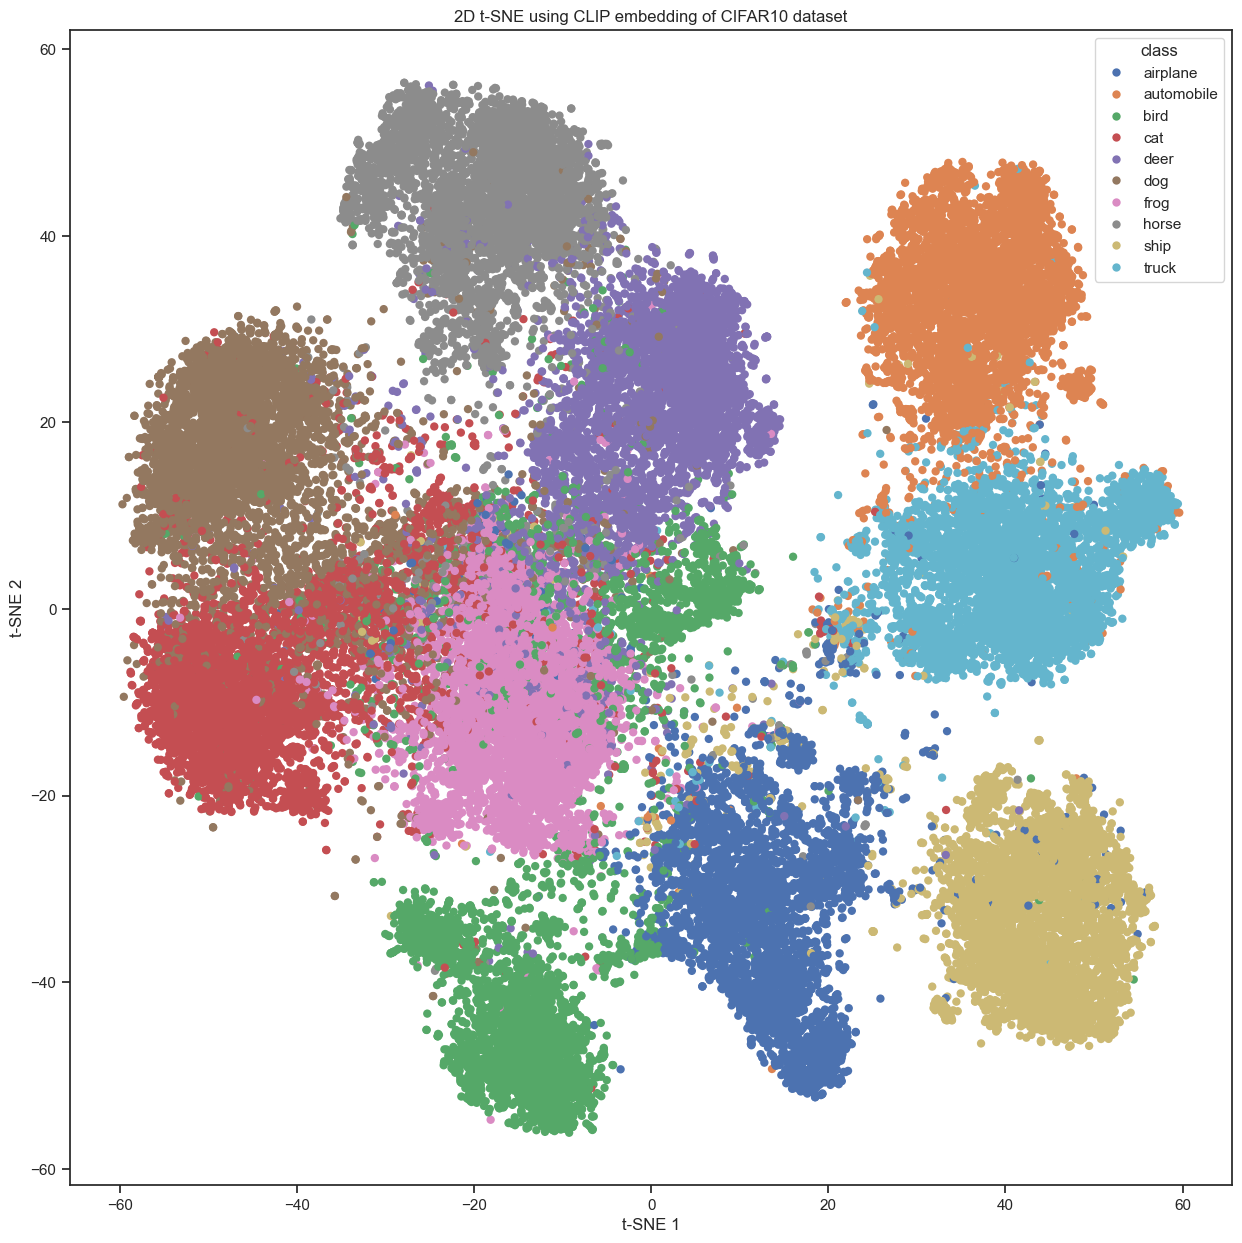

In [69]:
plt.figure(figsize=(12, 12))
tsne_results_embedded = pd.DataFrame(tsne_results_embedded, columns=['t-SNE 1', 't-SNE 2'])
tsne_results_embedded['class'] = [cifar10.classes[target] for target in cifar10.targets]
#plot using scatter

sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='class', data=tsne_results_embedded, hue_order=cifar10.classes,
                linewidth=0)
plt.title('2D t-SNE using CLIP embedding of CIFAR10 dataset')
plt.show()

6.- Aplicar K-Means (elegir K como cualquier valor entre 3 y 10 dependiendo del numero de clases en tu dataset), y clusterizar la data que esta proyectada en 2-D asumiendo que no tienes acceso a los labels. Plotear los clusters en codigos de color para los siguientes casos: PCA, Embedding-PCA, t-SNE y Embedding-t-SNE. Deberias tener 4 plots. Que clusters se ven mejor para ti? Por que?

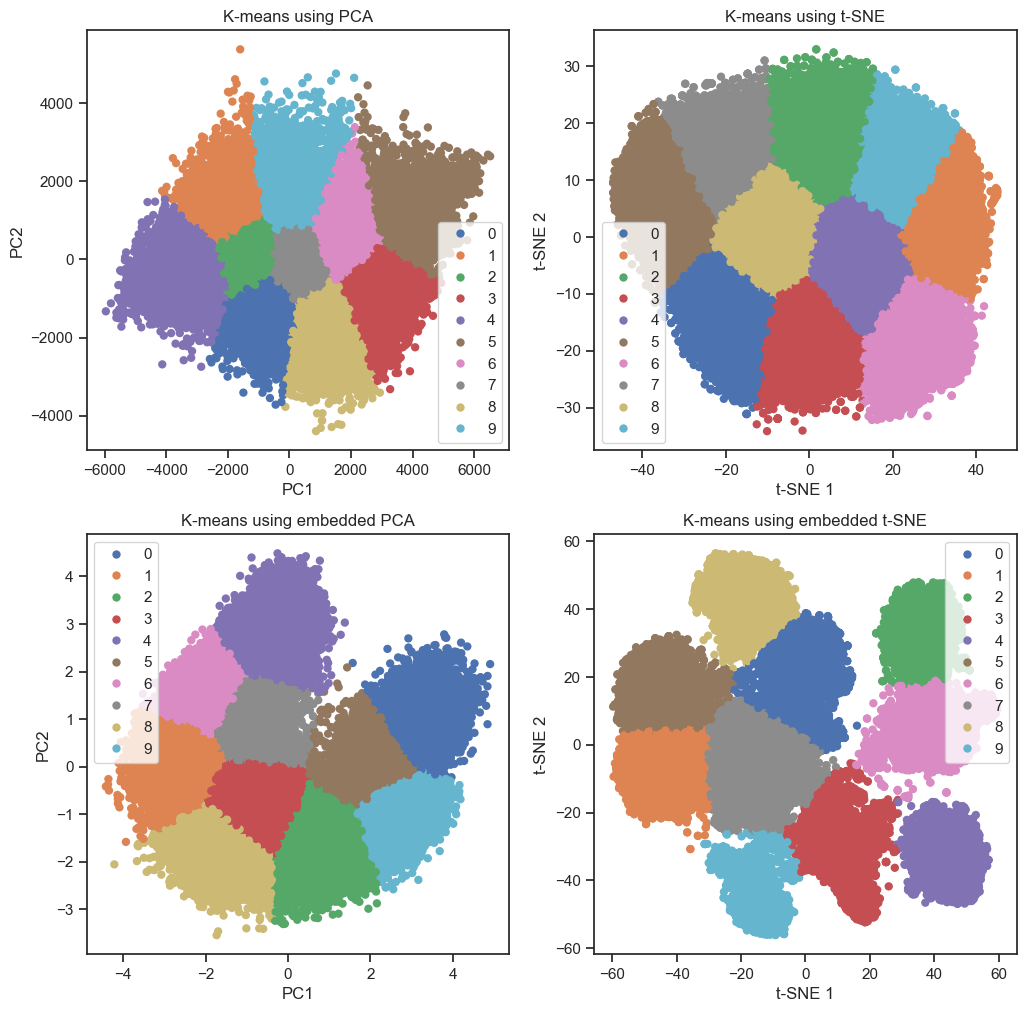

In [85]:
#K-means for PCA
kmeans_pca = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans_pca.fit(pcaU[['PC1', 'PC2']])

#K-means for t-SNE
kmeans_tsne = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans_tsne.fit(tsne_results[['t-SNE 1', 't-SNE 2']])

#K-means for embedded PCA
kmeans_embedded = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans_embedded.fit(pcaU_embedded[['PC1', 'PC2']])

#K-means for embedded t-SNE
kmeans_embedded_tsne = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans_embedded_tsne.fit(tsne_results_embedded[['t-SNE 1', 't-SNE 2']])

#plot all the clusters in the same image

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue=kmeans_pca.labels_, data=pcaU, palette='deep', linewidth=0)
plt.title('K-means using PCA')
plt.subplot(2, 2, 2)
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue=kmeans_tsne.labels_, data=tsne_results, palette='deep', linewidth=0)
plt.title('K-means using t-SNE')
plt.subplot(2, 2, 3)
sns.scatterplot(x='PC1', y='PC2', hue=kmeans_embedded.labels_, data=pcaU_embedded, palette='deep', linewidth=0)
plt.title('K-means using embedded PCA')
plt.subplot(2, 2, 4)
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue=kmeans_embedded_tsne.labels_, data=tsne_results_embedded, palette='deep', linewidth=0)
plt.title('K-means using embedded t-SNE')
plt.show()


7.- Aplicar Mean-Shift con un Gaussian Kernel y clusterizar la data que esta proyectada en 2-D asumiendo que no tienes acceso a los labels. Plotear los clusters en codigos de color para los siguientes casos: PCA, Embedding-PCA, t-SNE y Embedding-t-SNE. Deberias tener 4 plots. Que clusters se ven mejor para ti? Por que?

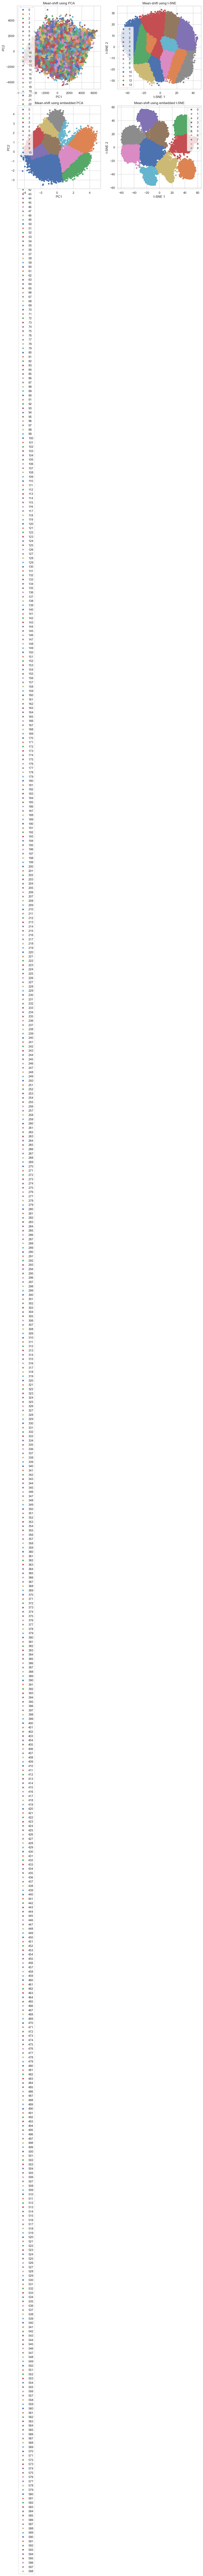

In [90]:
#using meanshift with a flat kernel

#Mean-shift for PCA
meanshift_pca = MeanShift(bandwidth=380)
meanshift_pca.fit(pcaU[['PC1', 'PC2']])
#Mean-shift for t-SNE
meanshift_tsne = MeanShift(bandwidth=8.4)
meanshift_tsne.fit(tsne_results[['t-SNE 1', 't-SNE 2']])
#Mean-shift for embedded PCA
meanshift_embedded = MeanShift(bandwidth=0.45)
meanshift_embedded.fit(pcaU_embedded[['PC1', 'PC2']])
#Mean-shift for embedded t-SNE
meanshift_embedded_tsne = MeanShift(bandwidth=13)
meanshift_embedded_tsne.fit(tsne_results_embedded[['t-SNE 1', 't-SNE 2']])

pca_predictions = meanshift_pca.predict(pcaU[['PC1', 'PC2']])
tsne_predictions = meanshift_tsne.predict(tsne_results[['t-SNE 1', 't-SNE 2']])
pca_embedded_predictions = meanshift_embedded.predict(pcaU_embedded[['PC1', 'PC2']])
tsne_embedded_predictions = meanshift_embedded_tsne.predict(tsne_results_embedded[['t-SNE 1', 't-SNE 2']])
#plot all the clusters in the same image

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue=pca_predictions, data=pcaU, palette='deep', linewidth=0)
plt.title('Mean-shift using PCA')
plt.subplot(2, 2, 2)
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue=tsne_predictions, data=tsne_results, palette='deep', linewidth=0)
plt.title('Mean-shift using t-SNE')
plt.subplot(2, 2, 3)
sns.scatterplot(x='PC1', y='PC2', hue=pca_embedded_predictions, data=pcaU_embedded, palette='deep', linewidth=0)
plt.title('Mean-shift using embedded PCA')
plt.subplot(2, 2, 4)
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue=tsne_embedded_predictions, data=tsne_results_embedded, palette='deep', linewidth=0)
plt.title('Mean-shift using embedded t-SNE')
plt.show()


 8.- Que algoritmo clusterizo la data mejor: K-Means o Mean-Shift? Por que? Cuanto crees que esto depende de PCA vs t-SNE o del tipo de embedding o de la data en bruto?

In [41]:
len(np.unique(meanshift_tsne.labels_))

7